In [133]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.autograd import Variable
from mpl_toolkits.mplot3d import Axes3D
print(torch.__version__)

1.1.0


In [134]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, transform = None):
        self.df = pd.read_csv('../data/train.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        return x
        
dataset = IMUDataset()

(120150, 8)


In [135]:
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(dataset) // reqd_len)]

trainloader = DataLoader(dataset, batch_size = batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)

In [96]:
signal = next(iter(trainloader))
print(signal.shape)

torch.Size([8, 150, 3])


In [136]:
# for xavier initialization of network
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class AutoEncoder(nn.Module) :
    def __init__(self) : 
        super(AutoEncoder, self).__init__()
        # defining layers
        self.encoder = nn.Sequential(
            nn.Linear(3 * 150, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 3 * 150),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.Softmax(dim = 1)
        )
        
    def forward(self, x, encode = False, classify = False) :
        x = x.view(-1, 3 * 150)
        features = self.encoder(x)
        
        if encode and not classify:
            return features
        elif not encode and classify :
            return self.classifier(features)
        else : 
            return self.decoder(features)

In [137]:
Net = AutoEncoder()
Net.apply(init_weights)
if torch.cuda.is_available() : 
    Net = Net.cuda()
    print('Model on GPU')

In [138]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-4)

In [139]:
num_epochs = 30
total_step = len(dataset) // (batch_size * 150)
train_loss_list = list()
min_loss = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, signals in enumerate(trainloader) :
        if torch.cuda.is_available():
            signals = Variable(signals).cuda().float()
        else : 
            signals = Variable(signals).float()
        
        reconstr = Net.forward(signals)
        flattened_sig = signal.view(-1, 3 * 150).float()
        loss = criterion(reconstr, flattened_sig)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    if train_loss < min_loss : 
        min_loss = train_loss
        torch.save(Net.state_dict() , '../saved_models/autoencoder2.pt')
        print('Saving model', min_loss)

epoch =  0  step =  0  of total steps  100  loss =  0.2574808597564697
epoch =  0  step =  20  of total steps  100  loss =  0.25041112303733826
epoch =  0  step =  40  of total steps  100  loss =  0.23580299317836761
epoch =  0  step =  60  of total steps  100  loss =  0.20421122014522552
epoch =  0  step =  80  of total steps  100  loss =  0.15118563175201416
Saving model 0.20258831322193147
epoch =  1  step =  0  of total steps  100  loss =  0.07984807342290878
epoch =  1  step =  20  of total steps  100  loss =  0.03770298883318901
epoch =  1  step =  40  of total steps  100  loss =  0.027723070234060287
epoch =  1  step =  60  of total steps  100  loss =  0.02478490024805069
epoch =  1  step =  80  of total steps  100  loss =  0.022018754854798317
Saving model 0.03197665212675929
epoch =  2  step =  0  of total steps  100  loss =  0.023305954411625862
epoch =  2  step =  20  of total steps  100  loss =  0.02102639339864254
epoch =  2  step =  40  of total steps  100  loss =  0.0208

epoch =  20  step =  80  of total steps  100  loss =  0.01932811737060547
Saving model 0.01950967475771904
epoch =  21  step =  0  of total steps  100  loss =  0.019158069044351578
epoch =  21  step =  20  of total steps  100  loss =  0.01973411627113819
epoch =  21  step =  40  of total steps  100  loss =  0.019567836076021194
epoch =  21  step =  60  of total steps  100  loss =  0.01943233236670494
epoch =  21  step =  80  of total steps  100  loss =  0.019723277539014816
Saving model 0.019507580660283564
epoch =  22  step =  0  of total steps  100  loss =  0.019703440368175507
epoch =  22  step =  20  of total steps  100  loss =  0.019610878080129623
epoch =  22  step =  40  of total steps  100  loss =  0.019230158999562263
epoch =  22  step =  60  of total steps  100  loss =  0.01922132819890976
epoch =  22  step =  80  of total steps  100  loss =  0.02054801769554615
Saving model 0.019455255195498466
epoch =  23  step =  0  of total steps  100  loss =  0.01927940361201763
epoch = 

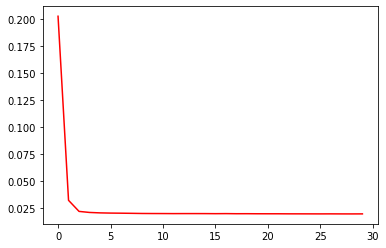

In [140]:
j = range(30)
plt.plot(j, train_loss_list, 'r')

### Verifying that AutoEncoder has not learnt the identity function

In [141]:
print(Net.encoder[0].weight)
print(Net.encoder[2].weight)
print(Net.decoder[0].weight)
print(Net.decoder[2].weight)

Parameter containing:
tensor([[-0.0418,  0.0569,  0.0090,  ..., -0.0308,  0.0710,  0.0931],
        [ 0.0170,  0.0871,  0.0744,  ..., -0.0032, -0.0771, -0.0138],
        [ 0.0379,  0.0401, -0.0255,  ...,  0.0219,  0.0481, -0.0566],
        ...,
        [-0.0258,  0.0052, -0.0870,  ..., -0.0020, -0.0787,  0.0894],
        [ 0.0171,  0.0493,  0.0094,  ..., -0.0297,  0.0264,  0.0366],
        [ 0.0831,  0.0338, -0.0395,  ...,  0.0987,  0.0535,  0.0544]],
       requires_grad=True)
Parameter containing:
tensor([[-0.0920, -0.0607, -0.0364,  ...,  0.0876,  0.1324, -0.0854],
        [-0.0394, -0.0213, -0.0647,  ..., -0.0899,  0.0595,  0.0411],
        [-0.0558, -0.0300,  0.0083,  ...,  0.0799,  0.0249,  0.0362],
        ...,
        [ 0.0821,  0.0387, -0.0743,  ..., -0.0483, -0.0643, -0.1067],
        [ 0.0151,  0.0664, -0.0856,  ...,  0.0997,  0.0942,  0.0543],
        [-0.0310,  0.0044,  0.1317,  ..., -0.0146, -0.0168, -0.1058]],
       requires_grad=True)
Parameter containing:
tensor([[-0.

### Now training the classifier

In [142]:
reqd_len = 150
channels = 3
class IMUDataset(Dataset):
    def __init__(self, mode = 'test', transform = None):
        if mode == 'train' :
            self.df = pd.read_csv('../data/train.csv', header = None)
        elif mode == 'test' :
            self.df = pd.read_csv('../data/test.csv', header = None)
        elif mode == 'val' :
            self.df = pd.read_csv('../data/val.csv', header = None)
        self.transform = transform
        print(self.df.shape)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        y = self.df.iloc[idx : idx + reqd_len, 3 : ].values
        ind = np.argmax(np.sum(y, axis = 0))
        label = np.zeros_like(self.df.iloc[0, 3 : ].values)
        label = label.astype('float')
        label[ind] = 1
        x = self.df.iloc[idx : idx + reqd_len, : channels].values
        x = x.astype('float')
        x = x.reshape(reqd_len, channels)
        assert(x.shape == (reqd_len, channels))
        assert(label.shape == (5, ))
        return x, label
        
trainset = IMUDataset(mode = 'train')
valset = IMUDataset(mode = 'val')
testset = IMUDataset(mode = 'test')

(120150, 8)
(19950, 8)
(20100, 8)


In [143]:
train_batch_size = 8
batch_size = 8
train_indices = [(i * reqd_len) for i in range(len(trainset) // reqd_len)]
val_indices = [(i * reqd_len) for i in range(len(valset) // reqd_len)]
test_indices = [(i * reqd_len) for i in range(len(testset) // reqd_len)]

trainloader = DataLoader(trainset, batch_size = train_batch_size, sampler = SubsetRandomSampler(train_indices), drop_last = True)
valloader = DataLoader(valset, batch_size = batch_size, sampler = SubsetRandomSampler(val_indices), drop_last = True)
testloader = DataLoader(testset, batch_size = batch_size, sampler = SubsetRandomSampler(test_indices), drop_last = True)

In [144]:
# Loading autoencoder saved model
Net = AutoEncoder()
Net.load_state_dict(torch.load('../saved_models/autoencoder2.pt'), strict = False)
# freezing encoder and decoder layers
Net.encoder[0].requires_grad = False
Net.encoder[2].requires_grad = False
Net.decoder[0].requires_grad = False
Net.decoder[2].requires_grad = False

In [145]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 1e-3)

In [146]:
num_epochs = 30
total_step = len(trainset) // (train_batch_size * 150)
train_loss_list = list()
val_loss_list = list()
min_val = 100
for epoch in range(num_epochs):
    trn = []
    Net.train()
    for i, (images, labels) in enumerate(trainloader) :
        if torch.cuda.is_available():
            images = Variable(images).cuda().float()
            labels = Variable(labels).cuda()
        else : 
            images = Variable(images).float()
            labels = Variable(labels)
        
        _, target = torch.max(labels, 1)

        y_pred = Net.forward(images, classify = True)
        
        loss = criterion(y_pred, target)
        trn.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_value_(Net.parameters(), 10)
        optimizer.step()

        if i % 20 == 0 :
            print('epoch = ', epoch, ' step = ', i, ' of total steps ', total_step, ' loss = ', loss.item())
            
    train_loss = (sum(trn) / len(trn))
    train_loss_list.append(train_loss)
    
    Net.eval()
    val = []
    with torch.no_grad() :
        for i, (images, labels) in enumerate(valloader) :
            if torch.cuda.is_available():
                images = Variable(images).cuda().float()
                labels = Variable(labels).cuda()
            else : 
                images = Variable(images).float()
                labels = Variable(labels)
                
            _, target = torch.max(labels, 1)

            # Forward pass
            outputs = Net.forward(images, classify = True)
            loss = criterion(outputs, target)
            val.append(loss)

    val_loss = (sum(val) / len(val)).item()
    val_loss_list.append(val_loss)
    print('epoch : ', epoch, ' / ', num_epochs, ' | TL : ', train_loss, ' | VL : ', val_loss)
    
    if val_loss < min_val :
        print('saving model')
        min_val = val_loss
        torch.save(Net.state_dict(), 'autoencoder_classifier.pt')

epoch =  0  step =  0  of total steps  100  loss =  1.6071008443832397
epoch =  0  step =  20  of total steps  100  loss =  1.2980406284332275
epoch =  0  step =  40  of total steps  100  loss =  1.5290096998214722
epoch =  0  step =  60  of total steps  100  loss =  1.4002912044525146
epoch =  0  step =  80  of total steps  100  loss =  1.769485354423523
epoch :  0  /  30  | TL :  1.5371715557575225  | VL :  1.4775699377059937
saving model
epoch =  1  step =  0  of total steps  100  loss =  1.7192925214767456
epoch =  1  step =  20  of total steps  100  loss =  1.5583525896072388
epoch =  1  step =  40  of total steps  100  loss =  1.3516579866409302
epoch =  1  step =  60  of total steps  100  loss =  1.5760551691055298
epoch =  1  step =  80  of total steps  100  loss =  1.4528909921646118
epoch :  1  /  30  | TL :  1.5080260503292084  | VL :  1.467862844467163
saving model
epoch =  2  step =  0  of total steps  100  loss =  1.4773060083389282
epoch =  2  step =  20  of total steps 

epoch :  18  /  30  | TL :  1.1622242802381515  | VL :  1.5435080528259277
epoch =  19  step =  0  of total steps  100  loss =  1.282453179359436
epoch =  19  step =  20  of total steps  100  loss =  1.1540074348449707
epoch =  19  step =  40  of total steps  100  loss =  1.268941879272461
epoch =  19  step =  60  of total steps  100  loss =  1.3151253461837769
epoch =  19  step =  80  of total steps  100  loss =  1.273633599281311
epoch :  19  /  30  | TL :  1.1590779787302017  | VL :  1.5406923294067383
epoch =  20  step =  0  of total steps  100  loss =  1.279401421546936
epoch =  20  step =  20  of total steps  100  loss =  1.1314572095870972
epoch =  20  step =  40  of total steps  100  loss =  1.0238876342773438
epoch =  20  step =  60  of total steps  100  loss =  1.2803223133087158
epoch =  20  step =  80  of total steps  100  loss =  1.0732214450836182
epoch :  20  /  30  | TL :  1.1500638103485108  | VL :  1.5465116500854492
epoch =  21  step =  0  of total steps  100  loss =

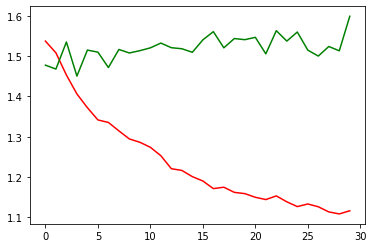

In [147]:
j = np.arange(30)
plt.plot(j, train_loss_list, 'r', j, val_loss_list, 'g')

In [148]:
def _get_accuracy(dataloader, Net):
    total = 0
    correct = 0
    Net.eval()
    for i, (images, labels) in enumerate(dataloader):
        images = Variable(images).float()
        labels = Variable(labels).float()

        outputs = Net(images, classify = True)
    
        _, label_ind = torch.max(labels, 1)
        _, pred_ind = torch.max(outputs, 1)
        
        # converting to numpy arrays
        label_ind = label_ind.data.numpy()
        pred_ind = pred_ind.data.numpy()
        
        # get difference
        diff_ind = label_ind - pred_ind
        # correctly classified will be 1 and will get added
        # incorrectly classified will be 0
        correct += np.count_nonzero(diff_ind == 0)
        total += len(diff_ind)

    accuracy = correct / total
    # print(len(diff_ind))
    return accuracy

Net = Net.cpu().eval()
# _get_accuracy(trainloader)

In [149]:
print(_get_accuracy(trainloader, Net))
print(_get_accuracy(testloader, Net))
print(_get_accuracy(valloader, Net))

0.7425
0.28125
0.3046875
